In [1]:
import kevlib as kl

%run $kl.common_import_script


import requests
import urllib.parse
from astropy.io import ascii as astro_ascii
from astropy.io import fits



from kevlib import common_import_script
%run $common_import_script
from astropy.coordinates import SkyCoord
from astroscrappy import detect_cosmics
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import lmfit
from kevlib.utils.plot import plot_images
from glob import glob
import kevlib.image as kli
from kevlib.utils import fix_byte_order
import urllib.parse
from astropy.io import ascii as astro_ascii
from scipy.ndimage import binary_dilation, binary_erosion


import shapely
from shapely.geometry import Polygon, Point

def is_point_inside_bounding_area(bounding_points, point_to_check):
    # Create a Polygon from the bounding points
    polygon = Polygon(bounding_points)
    
    # Create a Point object from the point to check
    point = Point(point_to_check)
    
    # Check if the point is within the polygon
    return polygon.contains(point)

def get_wcs(header):
    
    from astropy.wcs import WCS
    
    return WCS(header)


def get_frame_corners(wcs, header, mode=['equ', 'deg']):
    
    import astropy.units as u
    
    w = wcs
    
    end = header['NAXIS1'] - 1
    
    pixel_coords = [[0,0], [0, end], [end, end], [end, 0]]
    
    world_coords = []
    if 'equ' in mode:
        for c in pixel_coords:
            sky_coord = w.pixel_to_world(c[1],c[0])
            if 'rad' in mode:
                world_coords.append([sky_coord.ra.wrap_at(180*u.deg).rad, sky_coord.dec.rad])
            elif 'deg' in mode:
                world_coords.append([sky_coord.ra.deg, sky_coord.dec.deg])
            
    elif 'ecliptic' in mode:
        for c in pixel_coords:
            sky_coord = w.pixel_to_world(c[1],c[0]).geocentrictrueecliptic
            if 'rad' in mode:
                world_coords.append([sky_coord.lon.wrap_at(180*u.deg).rad, sky_coord.lat.rad])
            elif 'deg' in mode:
                world_coords.append([sky_coord.lon.deg, sky_coord.lat.deg])
    
    if mode == []:
        for c in pixel_coords:
            world_coords.append(w.pixel_to_world(c[1],c[0]))
    
    world_coords = np.vstack(world_coords)
    
    return world_coords

from astropy.stats import sigma_clipped_stats


def reduced_chi_squared(observed, expected, sigma, num_parameters):

    N = np.size(observed)
    nu = N - num_parameters
    chi2 = np.sum((observed - expected)**2 / sigma**2)
    chi2_red = chi2 / nu
    return chi2_red

def square_index(x_pix: int, y_pix: int,
                 square_size: int = 15,
                 image_width: int = 1016,
                 image_height: int = 1016):

    num_x = image_width  // square_size
    num_y = image_height // square_size

    if x_pix >= num_x * square_size or y_pix >= num_y * square_size:
        return None

    i = x_pix // square_size
    j = y_pix // square_size
    return i * num_y + j


/media/rd1/kwillis/kevlib_dev/src/kevlib/common_imports.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange  # 231010


---------------------------------------------------------------------------------------
|                        Last run date: 2025-07-12 04:36 PM E                         |
---------------------------------------------------------------------------------------
| Python | Jupyterlab | Numpy  | Scipy  | Astropy | Matplotlib | Tensorflow | Pytorch |
---------------------------------------------------------------------------------------
| 3.11.4 |   4.4.3    | 1.24.3 | 1.11.1 |  5.3.1  |   3.8.3    |   2.13.1   |  2.0.1  |
---------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------
|                        Last run date: 2025-07-12 04:36 PM E                         |
---------------------------------------------------------------------------------------
| Python | Jupyterlab | Numpy  | Scipy  | Astropy | Matplotlib | Tensorflow | Pytorch |
---------------------------------------------------------------------------------------
| 3.11.4 |   4.4.3    | 1.24.3 | 1.11.1 |  5.3.1  |   3.8.3    |   2.13.1   |  2.0.1  |
---------------------------------------------------------------------------------------


In [294]:
c = np.load("./Searches/v3_all_confidences_S1.npy")
len(c)

3389195

(array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08]),
 [Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$'),
  Text(0, 1000000.0, '$\\mathdefault{10^{6}}$'),
  Text(0, 10000000.0, '$\\mathdefault{10^{7}}$'),
  Text(0, 100000000.0, '$\\mathdefault{10^{8}}$')])

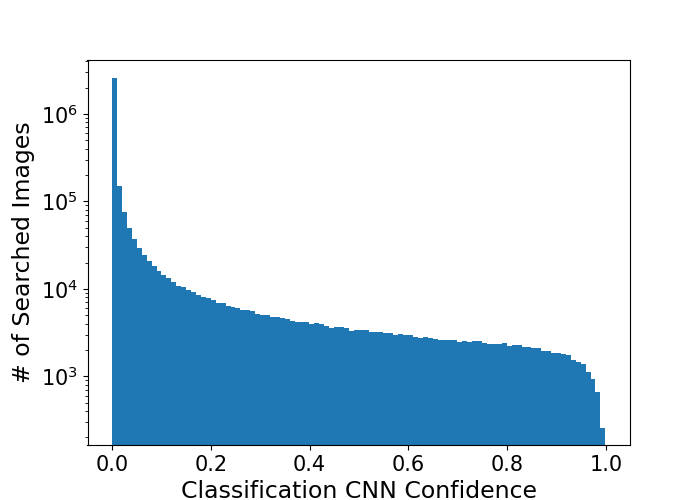

In [13]:
plt.figure(figsize=(7,5))
plt.yscale('log')
plt.hist(c ,bins=100)
plt.xlabel("Classification CNN Confidence", fontsize=17)
plt.ylabel("# of Searched Images", fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [14]:
len(c[c > 0.4])

153226

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [295]:
df = pd.read_csv("./all_irsa_searchregion_knownasteroids.csv")
df = df[df['source_id'].notna()].copy()
len(df)

7717

In [61]:
df

"""
filter out null frames
ask for same objid, check that there are >4 rows for this id
make the plot based on each detectoin in a chain for one objid
plot confidence above each image
"""

In [296]:
import numpy as np
import pandas as pd

grouped_rows = (
    df
    .groupby('objid', sort=False)
    .filter(lambda g: len(g) >= 4)
    .groupby('objid', sort=False)
    .apply(lambda g: g.to_numpy().tolist())
    .to_list()
)

nested_array = np.array(grouped_rows, dtype=object)

/tmp/ipykernel_32158/2426100459.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.to_numpy().tolist())


# Find indexes of known asteroid links from IRSA

In [23]:
# nested_array[0][0]

In [297]:
urls = np.load("./Searches/S1_URLs.npy")
urls = np.unique(urls)
len(urls)

755

In [20]:
from astropy.io import fits
hdul = fits.open(urls[0])
min1 = hdul[0].header["MJD_OBS"]
hdul = fits.open(urls[-1])
max1 = hdul[0].header["MJD_OBS"]

In [21]:
nested_array[-1]

[['(2034) Bernoulli        1973 EE',
  'A',
  54.894797,
  20.879581,
  0.02,
  49.8,
  1.97612,
  30.79,
  12.71,
  16.704,
  59809.78484581,
  '42222r137-001151',
  2.68,
  -1.7,
  -0.1,
  14.329,
  0.105,
  12.447,
  0.148,
  1867873],
 ['(2034) Bernoulli        1973 EE',
  'A',
  54.947411,
  20.900579,
  0.02,
  49.7,
  1.97589,
  30.795,
  12.71,
  16.702,
  59809.91523964,
  '42226r136-000669',
  0.35,
  -0.6,
  0.0,
  14.167,
  0.151,
  11.594,
  0.161,
  1867866],
 ['(2034) Bernoulli        1973 EE',
  'A',
  54.94746,
  20.900618,
  0.02,
  49.8,
  1.97589,
  30.795,
  12.71,
  16.702,
  59809.915367,
  '42226r137-000706',
  2.19,
  -1.5,
  -0.1,
  14.049,
  0.134,
  11.821,
  0.127,
  1867866],
 ['(2034) Bernoulli        1973 EE',
  'A',
  54.973753,
  20.911113,
  0.02,
  49.7,
  1.97578,
  30.797,
  12.71,
  16.701,
  59809.98056395,
  '42228r113-000879',
  2.04,
  -1.3,
  -0.8,
  13.93,
  0.11,
  12.498,
  0.185,
  1867868]]

In [24]:
from astropy.wcs import WCS
from astropy.io import fits
import numpy as np
from tqdm import tqdm

im_ind = []
all_chain_inds = []

for i in tqdm(range(len(nested_array))):
    chain_inds = []
    
    for s in range(len(nested_array[i])):

        num_urls = 0
        
        for url in urls:
            
            if url[77:86] == nested_array[i][s][11][:9]:
                
                hdul = fits.open(url)
                header = hdul[0].header
                wcs = get_wcs(header)
                c = SkyCoord(nested_array[i][s][2], nested_array[i][s][3], frame='icrs', unit='deg')
                x0, y0 = wcs.world_to_pixel(c)      
                
                ind = square_index(x0, y0)

                if ind is not None:
                
                    num_prev_frames = num_urls*4489
                    
                    final_ind = ind + num_prev_frames
                    
                    chain_inds.append(final_ind)

                break
                
            num_urls+=1

    all_chain_inds.append(chain_inds)

100%|██████████| 573/573 [02:38<00:00,  3.62it/s]


In [313]:
all_chain_inds[1000]

2925405

In [310]:
all_chain_inds = [int(n) for link in all_chain_inds for n in link]

In [311]:
len(all_chain_inds

2972

In [314]:
np.save("known_IRSA_indices_S1_pt4_tofilterW1rawims", all_chain_inds)

In [ ]:
nested_det_info = 

In [30]:
len(nested_array)

573

In [268]:
from kevlib.utils.io import mmcreate, mmload

all_ims = np.load("./Searches/2_S1_DarkPixelsRemoved_Normalized_FinalDeployGrids.npy")
all_confs = np.load("./Searches/v3_all_confidences_S1.npy")

all_chain_ims = []
all_chain_confs = []

all_chain_ras= []
all_chain_decs = []
all_chain_mjds = []
for i in range(len(all_chain_inds)):
    chain_ims = []
    chain_confs = []
    
    chain_ras = []
    chain_decs = []
    chain_mjds = []
    for j in range(len(all_chain_inds[i])):
        chain_ims.append(all_ims[int(all_chain_inds[i][j])])
        chain_confs.append(all_confs[int(all_chain_inds[i][j])])

        chain_ras.append()
        chain_decs.append()
        chain_mjds.append()
        
    all_chain_ims.append(chain_ims)
    all_chain_confs.append(chain_confs)
    all_chain_ras= []
    all_chain_decs = []
    all_chain_mjds = []

In [264]:
plt.close()

In [251]:
print(c)

[]


In [283]:
long_chain_ims = [c for c in all_chain_ims if len(c) > 3 ]
long_chain_confs = [c for c in all_chain_confs if len(c) > 3 ]

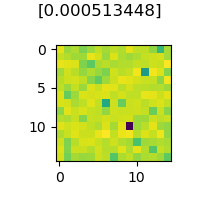

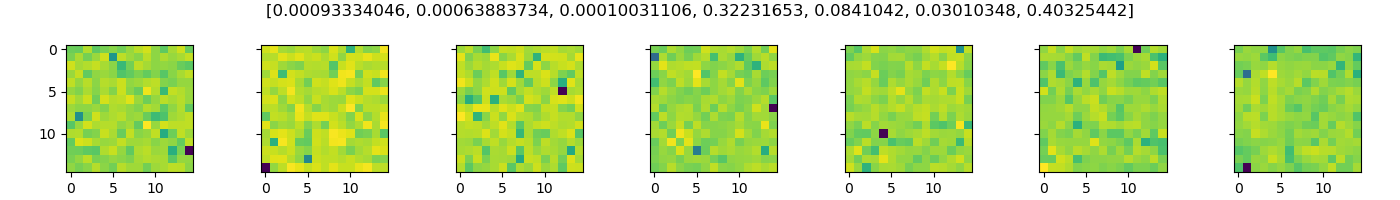

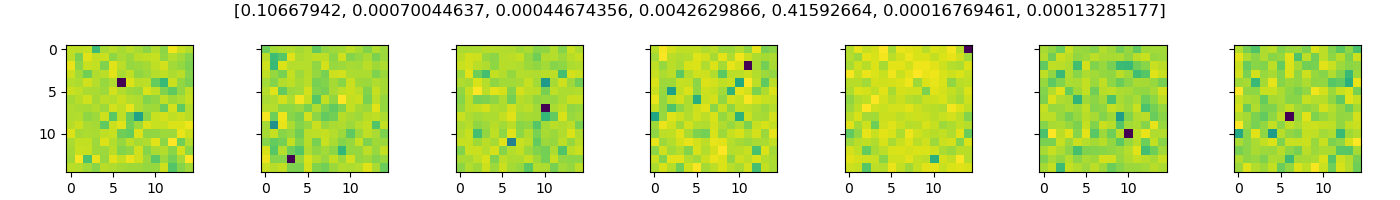

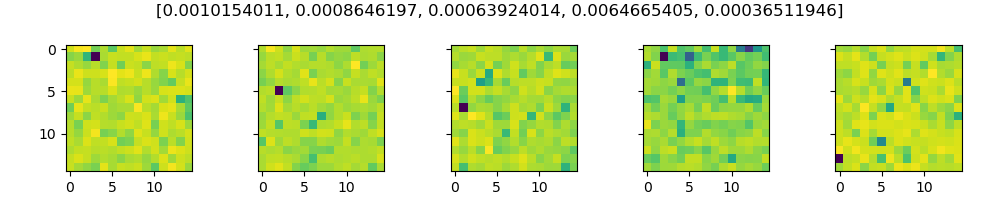

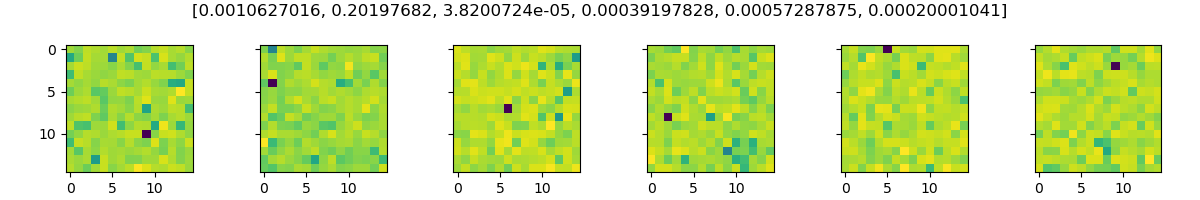

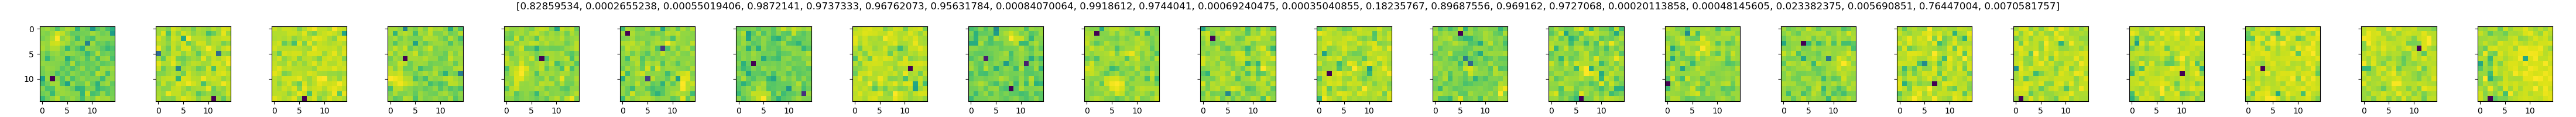

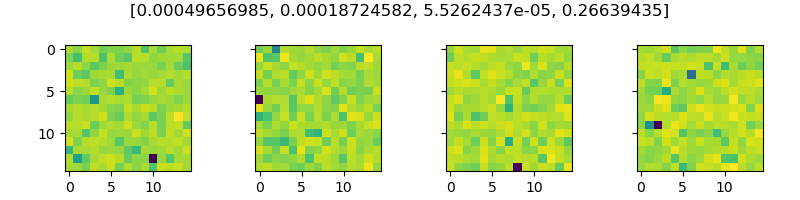

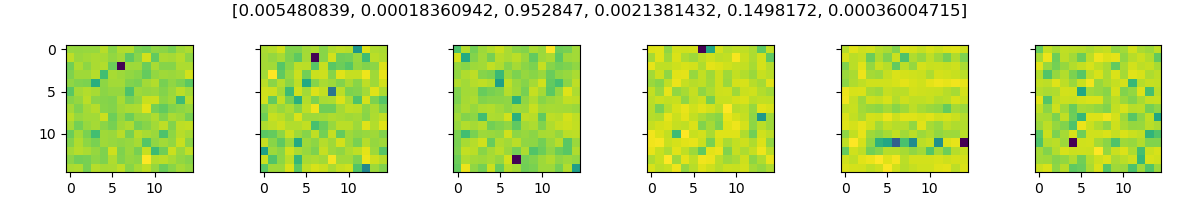

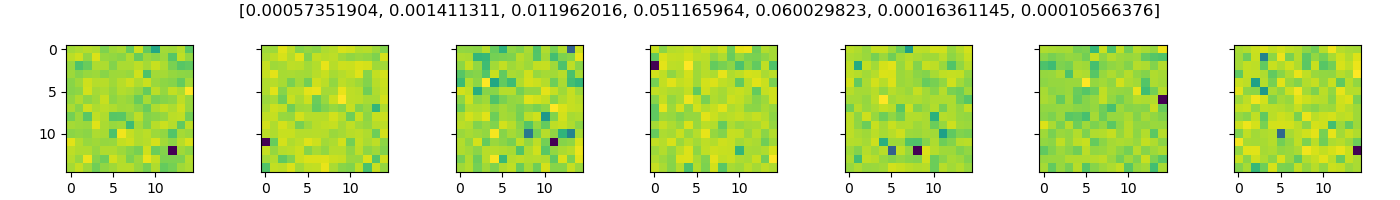

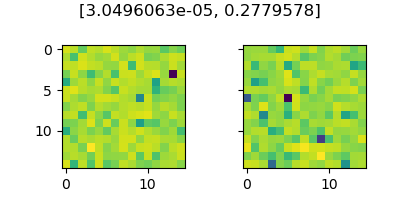

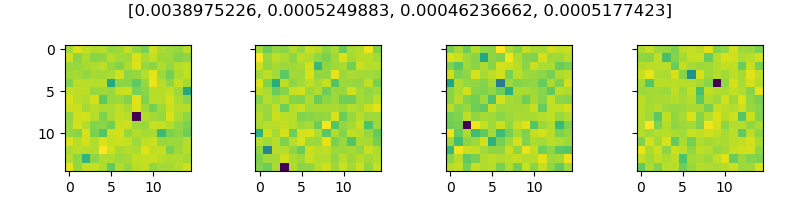

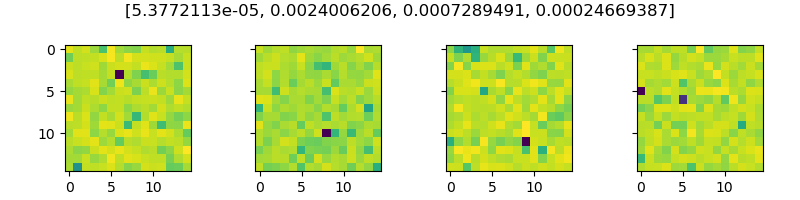

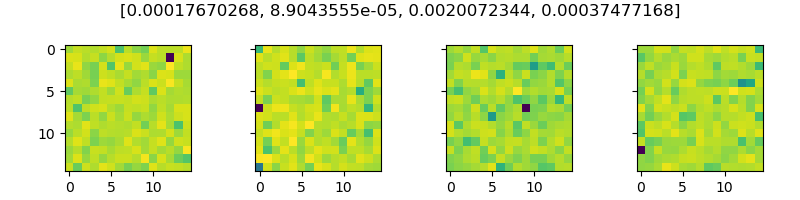

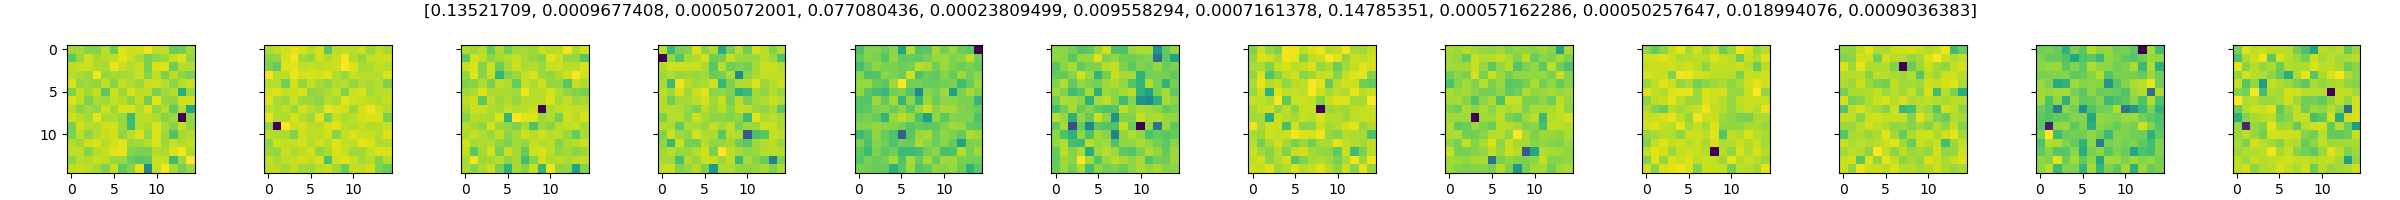

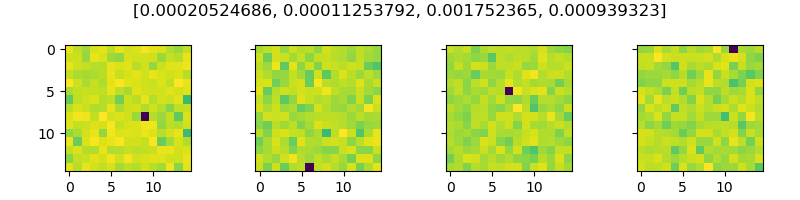

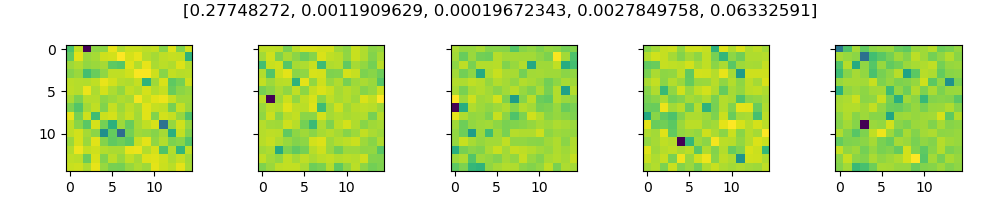

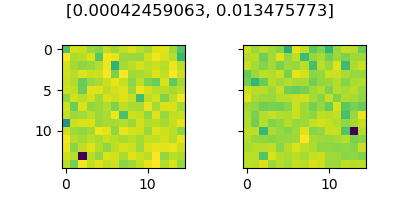

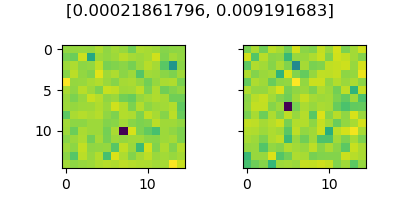

In [275]:
l = 80
h = 100
for c in range(len(all_chain_ims[l:h])):
    if all_chain_ims[c]:
        plot_images(all_chain_ims[c+l], fig_height=2, norm_same=False, title=(all_chain_confs[c+l]))

In [286]:
goo

399

In [295]:
good_speed_chains = [[int(s) for s in c] for c in all_chain_inds]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# predictedCoords  = np.load("./unique_pixCoords_v3_pt4.npy")
W2ims = np.load("./Searches/2_S1_DarkPixelsRemoved_Normalized_FinalDeployGrids.npy")
pos_confidences = np.load("./Searches/v3_all_confidences_S1.npy")

# bitmasks = np.load("./Searches/Mar19_Search_DarkPixelsRemoved_Normalized_bitmasks.npy")
# coadds   = np.load("./Searches/Mar19_Search_DarkPixelsRemoved_Normalized_coa.npy")

circle_radius = 2

row_titles    = ['W2ims']
image_arrays  = [W2ims] 
n_rows        = len(image_arrays)

# assert all(len(arr) == len(predictedCoords) for arr in image_arrays), \

pdf_filename = 'v3_IRSA_check_knowns.pdf'
with PdfPages(pdf_filename) as pdf:
    for chain_idx, chain in enumerate(good_speed_chains[:]):   # first 10 chains
        n = len(chain)
        if n < 1:
            continue 

        fig, axes = plt.subplots(
            n_rows, n,
            figsize=(n * 3, n_rows * 3),
            squeeze=False 
        )

        for col, img_idx in enumerate(chain):
            # Title with confidence on first (image) row
            conf = pos_confidences[img_idx]
            axes[0, col].set_title(f"Confidence: {conf:.2f}", fontsize=10)

            for row in range(n_rows):
                ax  = axes[row, col]
                img = image_arrays[row][img_idx]

                if img.ndim == 1 and img.size == 225:
                    img = img.reshape(15, 15)

                ax.imshow(img, cmap='gray', origin='lower')
                ax.axis('off')

                # draw predicted coordinate
                # x, y = predictedCoords[img_idx]
                # circ = plt.Circle((x, y), radius=circle_radius,
                #                   edgecolor='red', facecolor='none', linewidth=2)
                # ax.add_patch(circ)

                # label the image type once per row
                if col == 0:
                    ax.set_ylabel(row_titles[row], fontsize=12)

        fig.suptitle(f"Chain {chain_idx}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        pdf.savefig(fig)
        plt.close(fig)

print(f"PDF saved as '{pdf_filename}'")


PDF saved as 'v3_IRSA_check_knowns.pdf'


In [116]:
# grouped_rows = (
#     df
#     .groupby('objid', sort=False)
#     .filter(lambda g: len(g) >= 4)
#     .groupby('objid', sort=False)
#     .apply(lambda x: x.sort_values(by='mjd', ascending=True))
#     .apply(lambda g: g.to_numpy().tolist())
#     # .to_list()
# )
grouped_rows = (
    df
    .groupby('objid', sort=False)
    .filter(lambda g: len(g) >= 4)
    .groupby('objid', sort=False)
    .apply(lambda g: g.sort_values(by='mjd', ascending=True).to_numpy().tolist())
    .reset_index(drop=True)  # Optional, cleans up the index
)


/tmp/ipykernel_32158/2872857700.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values(by='mjd', ascending=True).to_numpy().tolist())


In [249]:
cnngood_speed_chains = []

with open('stspaper_good_speed_chains_4and5.txt', 'r') as f:
    for line in f:
        sublist = list(map(int, line.strip().split()))
        if len(sublist) >= 4:
            cnngood_speed_chains.append(sublist)

# new_ras = np.load("./S1_v3_Results/unique_ras_v3_pt4.npy")
# new_decs = np.load("./S1_v3_Results/pt4_Decs_CoordCNN.npy")
# new_mjds = np.load("./S1_v3_Results/pt4MJDs_CoordCNN.npy")

new_ras = np.load("./Crosschecked_Dets/unique_ras_v3_pt4.npy")
new_decs = np.load("./Crosschecked_Dets/unique_decs_v3_pt4.npy")
new_mjds = np.load("./Crosschecked_Dets/unique_mjds_v3_pt4.npy")

cnn_info = []
for c in cnngood_speed_chains:
    cu = []
    for d in c:
        cu.append([new_ras[d], new_decs[d], new_mjds[d]])
    cnn_info.append(cu)

cnn_first_last_coords = []


# [[g[0], g[1]] for g in cnn_info if len(g) >= 4]

In [250]:
for link in pos_cnn_info:
    mjds = [x[2] for x in link]
    min_idx = mjds.index(min(mjds))
    max_idx = mjds.index(max(mjds))
    cnn_first_last_coords.append([link[min_idx], link[max_idx]])

In [251]:
len(cnn_first_last_coords)

584

In [252]:
pos_cnn_info = []
for c in cnn_info:
    if c[0][0] < c[1][0]:
        pos_cnn_info.append(c)
len(pos_cnn_info)

898

In [278]:
# cnnslopes = []
# for chain in cnn_first_last_coords:
#     delta_x = chain[1][0] - chain[0][0]
#     delta_y = chain[1][1] - chain[0][1]
#     theta_radians = math.atan2(delta_y, delta_x)
#     theta_degrees = math.degrees(theta_radians)
#     cnnslopes.append(theta_degrees)

cnnslopes =np.load("pt4_S1_898_4_5_chains_SLOPES.npy")

In [152]:
import math
# grouped_rows[0]
first_last_coords = [[g[0], g[-1]] for g in grouped_rows if len(g) >= 4]
# first_last_coords = [[g[2], g[3], g[10]] for g in first_last_coords]
slopes = []
for chain in first_last_coords:
    delta_x = chain[1][2] - chain[0][2]
    delta_y = chain[1][3] - chain[0][3]
    theta_radians = math.atan2(delta_y, delta_x)
    theta_degrees = math.degrees(theta_radians)
    slopes.append(theta_degrees)

In [330]:
# print(slopes.index(min(slopes)), min(slopes), first_last_coords[248])
# first_last_coords[567]
# correct_inds = [i for i in range(len(cnnslopes)) if (cnnslopes[i] > -1.12) & (cnnslopes[i] < 34.44)]
# correct_inds = [i for i in range(len(cnnslopes)) if (cnnslopes[i] < -45)]

correct_inds = np.arange(len(cnnslopes))
# correct_inds = [i for i in range(len(slopes)) if (slopes[i] < 0)]
len(correct_inds)
# print(correct_inds)

898

In [279]:
cnn_first_last_coords = np.load("./pt4_S1_898_4_5_chains_FIRST_LASTs.npy")

Text(0, 0.5, 'Dec.')

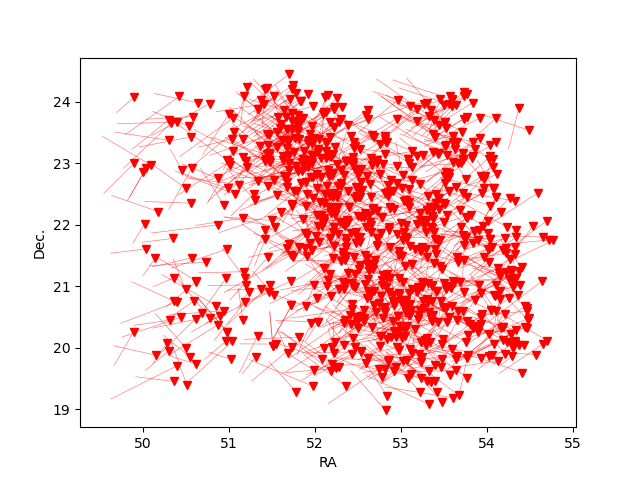

In [331]:

# plt.figure()
# for i in range(len(first_last_coords)):
#     # if i in correct_inds:
#     plt.plot([first_last_coords[i][0][2], first_last_coords[i][1][2]], [first_last_coords[i][0][3], first_last_coords[i][1][3]], "-b", linewidth=0.5)
#     plt.plot(first_last_coords[i][1][2], first_last_coords[i][1][3], "bv")

plt.figure()
for i in range(len(cnn_first_last_coords)):
    if i in correct_inds:
        plt.plot([cnn_first_last_coords[i][0][0], cnn_first_last_coords[i][1][0]], [cnn_first_last_coords[i][0][1], cnn_first_last_coords[i][1][1]], "-r", linewidth=0.5, alpha=0.5)
        plt.plot(cnn_first_last_coords[i][1][0], cnn_first_last_coords[i][1][1], "rv")

plt.xlabel("RA")
plt.ylabel("Dec.")

In [286]:
plt.close()

In [241]:
x = 248

# 248, NEA

first_last_coords[x], slopes[x]

In [136]:
cnnslopes.index(min(cnnslopes)), min(cnnslopes)

(378, -178.60718662861)

In [264]:
len([[c, i] for i, c in enumerate(cnnslopes) if (c < 34.44) and (c > 0)])

169

In [89]:
len(cnn_first_last_coords)

898

In [245]:
data_mean + 3 * data_std

43.33213229036792

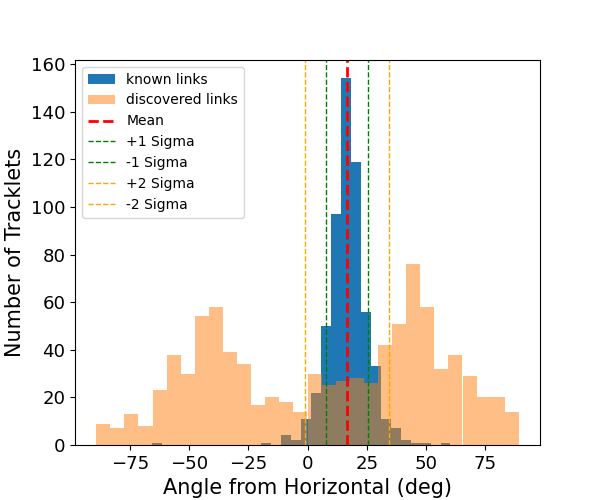

In [334]:
data_std = np.std(slopes)
data_mean = np.mean(slopes)

plt.figure(figsize=(6,5))
plt.hist(slopes, bins=30, label="known links")
plt.hist(cnnslopes, bins=30, alpha=0.5, label="discovered links")

f = 15
plt.xlabel("Angle from Horizontal (deg)", fontsize=f)
plt.ylabel("Number of Tracklets", fontsize=f)
plt.xticks(fontsize=f-2)
plt.yticks(fontsize=f-2)

plt.axvline(data_mean, color='red', linestyle='dashed', linewidth=2, label='Mean')  # Plot a dashed red line for the mean

plt.axvline(data_mean + data_std, color='green', linestyle='dashed', linewidth=1, label='+1 Sigma')  # Plot a dashed green line at +1 sigma
plt.axvline(data_mean - data_std, color='green', linestyle='dashed', linewidth=1, label='-1 Sigma')  # Plot a dashed green line at -1 sigma

plt.axvline(data_mean + 2 * data_std, color='orange', linestyle='dashed', linewidth=1, label='+2 Sigma')  # Plot a dashed orange line at +2 sigma
plt.axvline(data_mean - 2* data_std, color='orange', linestyle='dashed', linewidth=1, label='-2 Sigma')  # Plot a dashed orange line at -2 sigma


plt.legend()
# plt.title("Known Asteroid Trajectories' Angles from \nHorizontal in Search Region")

In [332]:
data_mean - 2 * data_std

-1.1260090623519794

In [257]:
# first_last_coords[0]

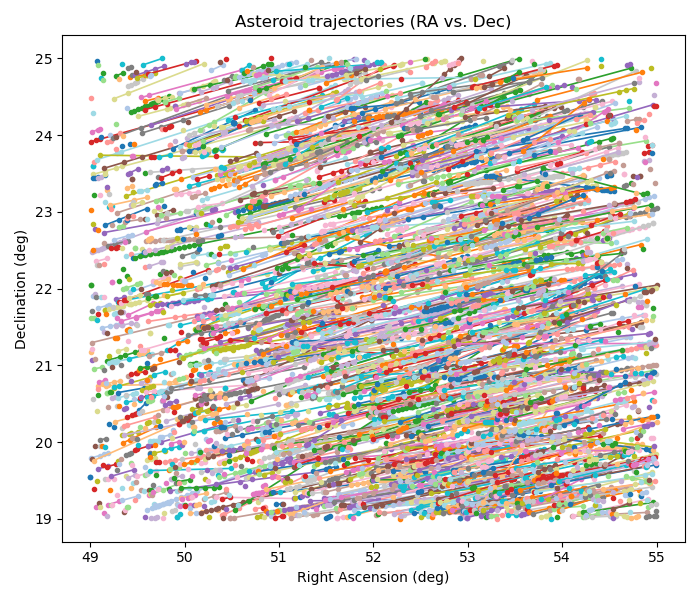

In [34]:
import matplotlib.pyplot as plt

ra='ra'
dec='dec'
time='mjd'

max_legend=20
figsize=(7,6)

df_subset = df
fig, ax = plt.subplots(figsize=figsize)
cmap = plt.get_cmap('tab20')

for i, (oid, grp) in enumerate(df_subset.groupby('objid', sort=False)):
    g = grp.sort_values(time)
    ax.plot(g[ra], g[dec],
            marker='o', markersize=3,
            linewidth=1.2,
            color=cmap(i % cmap.N),
            label=str(oid) if i < max_legend else None)

ax.set_xlabel('Right Ascension (deg)')
ax.set_ylabel('Declination (deg)')
ax.set_title('Asteroid trajectories (RA vs. Dec)')
if df_subset['objid'].nunique() <= max_legend:
    ax.legend(fontsize='small')
plt.tight_layout()
plt.show()

# plot_ra_dec_links(df)

In [37]:
df.groupby('objid', sort=False).first()

,t,ra,dec,mu,theta,rhelio,phase,amag,vmag,mjd,source_id,mconf,dra,ddec,w1mpro,w1sgmp,w2mpro,w2sgmp,ff_healpix_idx
objid,,,,,,,,,,,,,,,,,,,
2014 HJ133,U,49.002423,19.543308,0.007,52.1,3.24921,18.098,17.25,23.144,59810.307058,42238r134-000731,6.47,-1.9,2.1,14.484,0.107,14.392,0.485,1730019
(14719) Sobey 2000 CB85,A,49.007523,19.791580,0.017,51.0,2.06398,29.390,14.86,19.007,59805.154214,42080r112-005355,1.67,1.4,1.1,16.463,0.360,14.329,0.311,1733270
(H8706) 2000 SK168,A,49.008421,23.022587,0.011,49.9,2.67328,22.261,15.51,20.701,59805.610210,42094r132-001354,13.45,-3.0,3.0,15.335,0.147,14.249,0.372,1818271
(n8678) 2008 SU223,A,49.009010,21.175510,0.013,51.5,2.34703,25.483,17.43,22.010,59810.372000,42240r108-003255,15.61,-6.4,0.1,16.103,NaN,13.665,0.366,1803002
(w0402) 2015 BO390,A,49.010173,22.041383,0.010,46.0,2.79733,21.226,17.26,22.630,59805.414619,42088r108-000519,3.50,1.5,1.4,14.076,0.059,13.873,0.154,1811869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
(97899) 2000 QO74,A,54.979259,21.337009,0.015,53.0,2.05390,29.505,16.41,20.561,59809.980437,42228r112-001336,11.36,1.5,-3.6,15.151,NaN,12.089,0.179,1869359
2016 NH88,U,54.980053,23.372356,0.009,48.4,2.98057,19.829,17.75,23.336,59813.958849,42350r132-001612,12.81,0.4,-4.0,15.333,0.150,14.882,NaN,1895136
2020 FV18,U,54.988689,24.679255,0.009,31.9,3.10055,19.037,18.00,23.751,59813.697806,42342r130-001493,13.55,-2.9,3.0,15.150,0.122,14.792,NaN,1989345


In [80]:
# plt.figure()
# plt.hist(lens)

In [318]:
new_ras = np.load("./S1_v3_Results/pt4_RAs_CoordCNN.npy")
new_decs = np.load("./S1_v3_Results/pt4_Decs_CoordCNN.npy")
new_mjds = np.load("./S1_v3_Results/pt4MJDs_CoordCNN.npy")

In [319]:
df = pd.read_csv("./all_irsa_searchregion_knownasteroids.csv")

known_ras = df["ra"]
known_decs = df["dec"]
known_mjds = df["mjd"]
known_dists_ras = df["dra"]
known_dists_decs = df["ddec"]

In [320]:
import numpy as np

new_ras   = np.asarray(new_ras,   dtype=float)
new_decs  = np.asarray(new_decs,  dtype=float)
new_mjds  = np.asarray(new_mjds,  dtype=float)

known_ras  = np.asarray(known_ras,  dtype=float)
known_decs = np.asarray(known_decs, dtype=float)
known_mjds = np.asarray(known_mjds, dtype=float)

tol_ra  = 0.011 # deg ~15 pixels
tol_dec = 0.011 # deg ~ 15 pixels
tol_mjd = 5.787e-5#  5sec

matches = []
for ra, dec, mjd in zip(new_ras, new_decs, new_mjds):
    diff_ra  = np.abs(known_ras  - ra)
    diff_dec = np.abs(known_decs - dec)
    diff_mjd = np.abs(known_mjds - mjd)

    hit_mask = (diff_ra <= tol_ra) & (diff_dec <= tol_dec) & (diff_mjd <= tol_mjd)

    matches.append(np.nonzero(hit_mask)[0].tolist())

matched_mask   = np.array([len(m) > 0 for m in matches], dtype=bool)
unmatched_mask = ~matched_mask


In [321]:
np.save("matched_irsa_knowns_S1_pt4_v3", matched_mask)

In [277]:
np.save("./Crosschecked_Dets/unique_ras_v3_pt4.npy", new_ras[~matched_mask])
np.save("./Crosschecked_Dets/unique_decs_v3_pt4.npy", new_decs[~matched_mask])
np.save("./Crosschecked_Dets/unique_mjds_v3_pt4.npy", new_mjds[~matched_mask])

In [279]:
ims = np.load("./Searches/v3_images_pt4.npy")
ims  = ims[~matched_mask]
np.save("./unique_Images_v3_pt4", ims)


pxs = np.load("./Searches/v3_predicted_CoordinatesPixels_pt4.npy")
pxs  = pxs[~matched_mask]
np.save("./unique_pixCoords_v3_pt4.npy", pxs)

In [159]:
to_link_ras = new_ras[unmatched_mask]
to_link_decs = new_decs[unmatched_mask]
to_link_mjds = new_mjds[unmatched_mask]

In [160]:
len(to_link_ras)

143561

In [33]:
%matplotlib ipympl

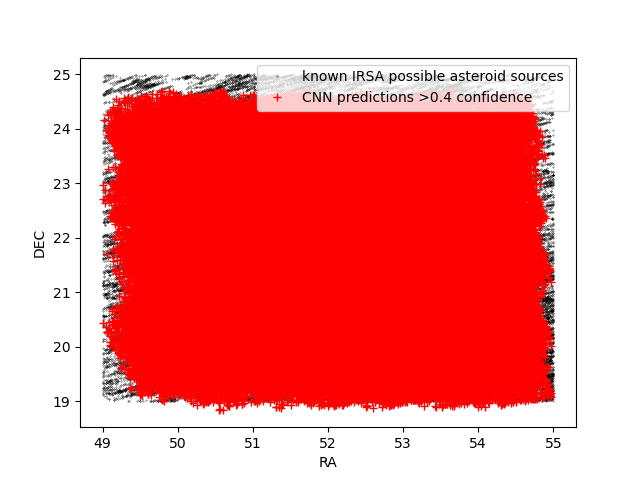

In [297]:
plt.figure()
plt.plot(known_ras, known_decs, ".k", markersize=0.5, label="known IRSA possible asteroid sources")
# plt.plot(new_ras, new_decs, ".b", alpha=0.5)
# plt.plot(mpc_ras, mpc_decs, "+g", alpha=0.5)
plt.xlabel("RA")
plt.ylabel("DEC")
plt.plot(new_ras[~matched_mask], new_decs[~matched_mask], "+r", label="CNN predictions >0.4 confidence")
plt.legend()

# look at all irsa detections and check confidence, plot histogram 
# of confidences for the 8k

In [29]:
mpc_ras =np.load("./known_asteroids_S1_Numbered_RAs.npy")
mpc_decs=np.load("./known_asteroids_S1_Numbered_Decs.npy")
mpc_mjds =np.load("./known_asteroids_S1_Numbered_MJDs.npy")